In [1]:
import os, sys
import numpy as np
import time
import matplotlib.pyplot as plt
import xarray as xr
import scipy
from pathlib import Path

from generate_sim_data import gen_rho, gen_sim_data
from load_ARSENL_data import load_INPHAMIS_data, set_binwidth, data_dir, fname, picklename

import matplotlib as mpl
mpl.rcParams.update({"figure.facecolor": "white"})

# Muller Correction on Fine Targets Using Coarse Resolution

This test is to confirm that the Muller correction can only be applied to uniform scenes. This is to clarify that this is a scene-defined issue, not a user-defined one. Simply smoothing over high-variability targets (i.e., targets that vary on the order of the deadtime interval) results in inaccurate estimates when using the Muller correction. To test this, I simulate a scene with a singular, narrow Gaussian pulse accumulated at high resolution (i.e., sub-pulse-width resolution). Then I bin to a single large bin that satisfies the Muller requirement ($\Delta t\gg\tau$).

If $\rho(t)$ is gaussian, then the true average value over a single bin (of width $T$) is 
$$\bar{\rho}(t)=\frac{1}{T}\int_{0}^{T}\rho(t')dt'=\frac{1}{T}\int_{0}^{T}\left(A\exp(-\frac{(t'-\mu)^2}{2\sigma^2})+b\right)dt'$$
$$\bar{\rho}(t)=\frac{1}{T}\sqrt{\frac{\pi}{2}}A\sigma\left(erf\left(\frac{T-\mu}{\sqrt{2}\sigma}\right)-erf\left(-\frac{\mu}{\sqrt{2}\sigma}\right)\right)+b$$

This value is compared to the Muller corrected estimate:
$$\hat{\rho}=\frac{\rho_m}{1-\rho_m\tau}$$
where $\rho_m=\frac{N}{TN_{shots}}$. $N$ is the total accumulated counts in the single bin.

# Generate Simulated Data

In [2]:
home = str(Path.home())
save_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\Data\Muller_Test_Simulated'

In [3]:
# amplitude = np.array([2.5e5, 5e5, 1e6, 2.5e6, 5e6, 1e7, 2.5e7, 5e7, 1e8])  # [Hz]
# amplitude = np.array([5e7, 1e8, 2.5e8, 5e8])  # [Hz]
amplitude = np.array([2.5e5, 5e5, 1e6, 2.5e6, 5e6])

# simulation resolution settings
t_sim_min = 0  # [s]
t_sim_max = 20000e-9  # [s]
dt_sim = 25e-9  # [s]

tD = 25e-9  # [s] deadtime
Nshot = int(1e5)  # number of laser shots
wrap_deadtime = False  # wrap deadtime between shots
window_bnd = [t_sim_min, t_sim_max]  # [s] time-of-flight bounds
laser_pulse_width = 250e-9  # [s] laser pulse width (sigma)
target_time = 10000e-9  # [s] target location in time
background = 1e1  # [Hz] background count rate (dark count)

In [ ]:
for i in range(len(amplitude)):
    
    target_amplitude = amplitude[i]
    
    ### GENERATE SIMULATED DATA ###
    det_idx, phot_idx, sync_idx, det_sync_idx, phot_sync_idx, det_events, phot_events = gen_sim_data(t_sim_max, dt_sim,
                                                                                                     tD, Nshot,
                                                                                                     wrap_deadtime,
                                                                                                     window_bnd,
                                                                                                     laser_pulse_width,
                                                                                                     target_time,
                                                                                                     target_amplitude,
                                                                                                     background)

    time_tag_index = det_idx
    true_time_tag_index = phot_idx
    sync_index = sync_idx
    time_tag = det_events
    true_time_tag = phot_events
    time_tag_sync_index = det_sync_idx
    true_time_tag_sync_index = phot_sync_idx

    # Save simulated data to netCDF
    sim_data = xr.Dataset(
        data_vars=dict(
            time_tag=(['time_tag_index'], time_tag),
            time_tag_sync_index=(['time_tag_index'], time_tag_sync_index),
            true_time_tag=(['true_time_tag_index'], true_time_tag),
            true_time_tag_sync_index=(['true_time_tag_index'], true_time_tag_sync_index),
            laser_pulse_width=laser_pulse_width,
            target_time=target_time,
            target_amplitude=target_amplitude,
            background=background,
            t_sim_min=t_sim_min,
            t_sim_max=t_sim_max,
            dt_sim=dt_sim,
            tD=tD,
            window_bnd=window_bnd,
            wrap_deadtime=wrap_deadtime
        ),
        coords=dict(
            sync_index=(['sync_index'], sync_index)
        )
    )

    fname = r'\sim_amp{:.1E}_nshot{:.1E}_pwidth_{:.1E}.nc'.format(target_amplitude, Nshot, laser_pulse_width*1e9)
    sim_data.to_netcdf(save_dir+fname)

time elapsed: 41.60564613342285
time elapsed: 53.500004291534424


In [20]:
# Analytic average of true function
subdir = r'\subset_pwidth_2.5E+02\\'

erf = scipy.special.erf
files = os.listdir(save_dir + subdir)

t_sim_min = 0  # [s]

true_flux = np.zeros(len(files))
det_flux = np.zeros(len(files))
muller_flux = np.zeros(len(files))
for i in range(len(files)):
    fname = files[i]
    ds = xr.open_dataset(save_dir + subdir + fname)

    start = time.time()

    cnts = ds.time_tag
    dt = ds.dt_sim
    flight_time = cnts * dt  # [s]
    # Exclude specified t.o.f. bins
    flight_time = flight_time[np.where((flight_time >= window_bnd[0]) & (flight_time < window_bnd[1]))]
    n_shots = len(ds.sync_index)
    
    A = ds.target_amplitude.to_numpy()  # [Hz]
    sigma = ds.laser_pulse_width  # [s]
    mu = ds.target_time  # [s]
    b = ds.background  # [Hz]
    t_sim_max = ds.t_sim_max
    tD = ds.tD
    
    T = t_sim_max - t_sim_min

    ds.close()
    
    bin_array = set_binwidth(t_sim_min, t_sim_max, dt)
    n, bins = np.histogram(flight_time, bins=bin_array)

    # Detected flux over single bin
    n_tot = np.sum(n)
    binwidth_tot = T  # [s]
    rho_avg_det = n_tot / binwidth_tot / n_shots  # [Hz]

    # True flux over single bin
    rho_avg_true = 1/T*(np.sqrt(np.pi/2)*A*sigma*erf((T-mu)/np.sqrt(2)/sigma)+b*T-np.sqrt(np.pi/2)*A*sigma*erf(-mu/np.sqrt(2)/sigma))  # [Hz]

    # Apply Muller correction
    rho_avg_Muller = rho_avg_det / (1 - tD*rho_avg_det)
    
    true_flux[i] = rho_avg_true
    det_flux[i] = rho_avg_det
    muller_flux[i] = rho_avg_Muller
    
sort_idx = np.argsort(true_flux)
true_flux = true_flux[sort_idx]
det_flux = det_flux[sort_idx]
muller_flux = muller_flux[sort_idx]

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


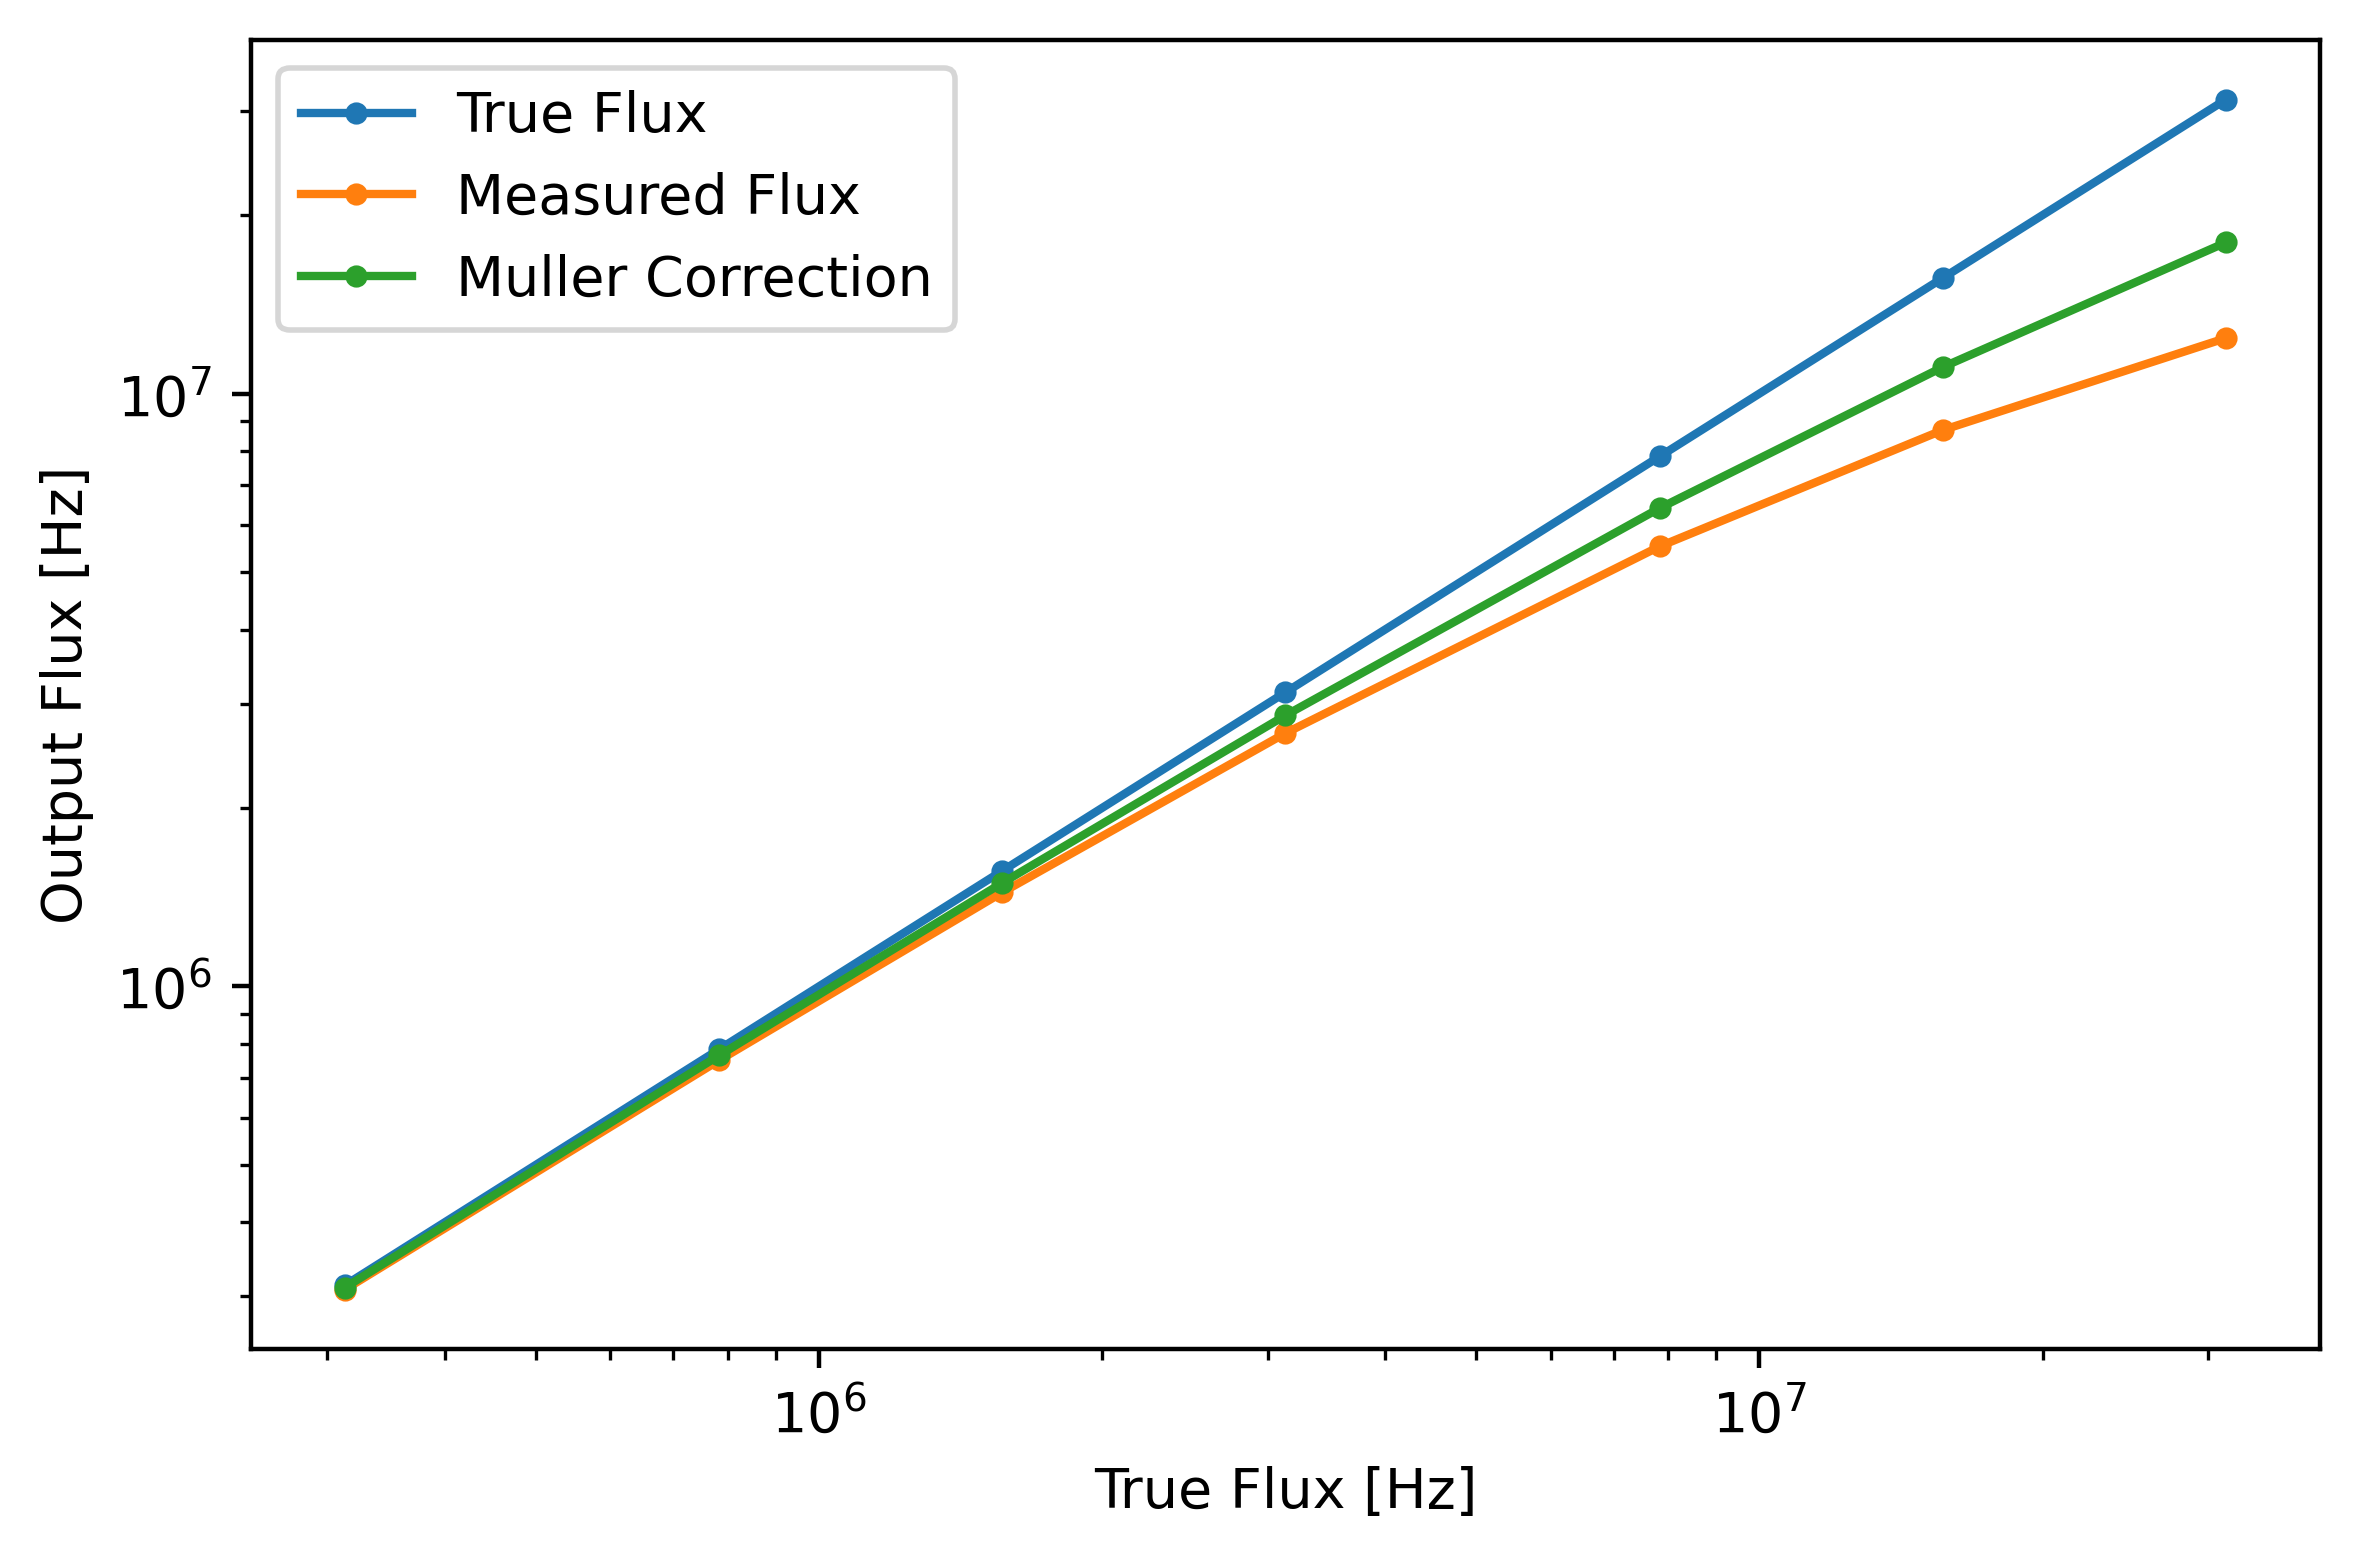

In [22]:
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)
ax.plot(true_flux[2:], true_flux[2:], marker='.', label='True Flux')
ax.plot(true_flux[2:], det_flux[2:], marker='.', label='Measured Flux')
ax.plot(true_flux[2:], muller_flux[2:], marker='.', label='Muller Correction')
ax.set_xlabel('True Flux [Hz]')
ax.set_ylabel('Output Flux [Hz]')
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# View Simulated Data

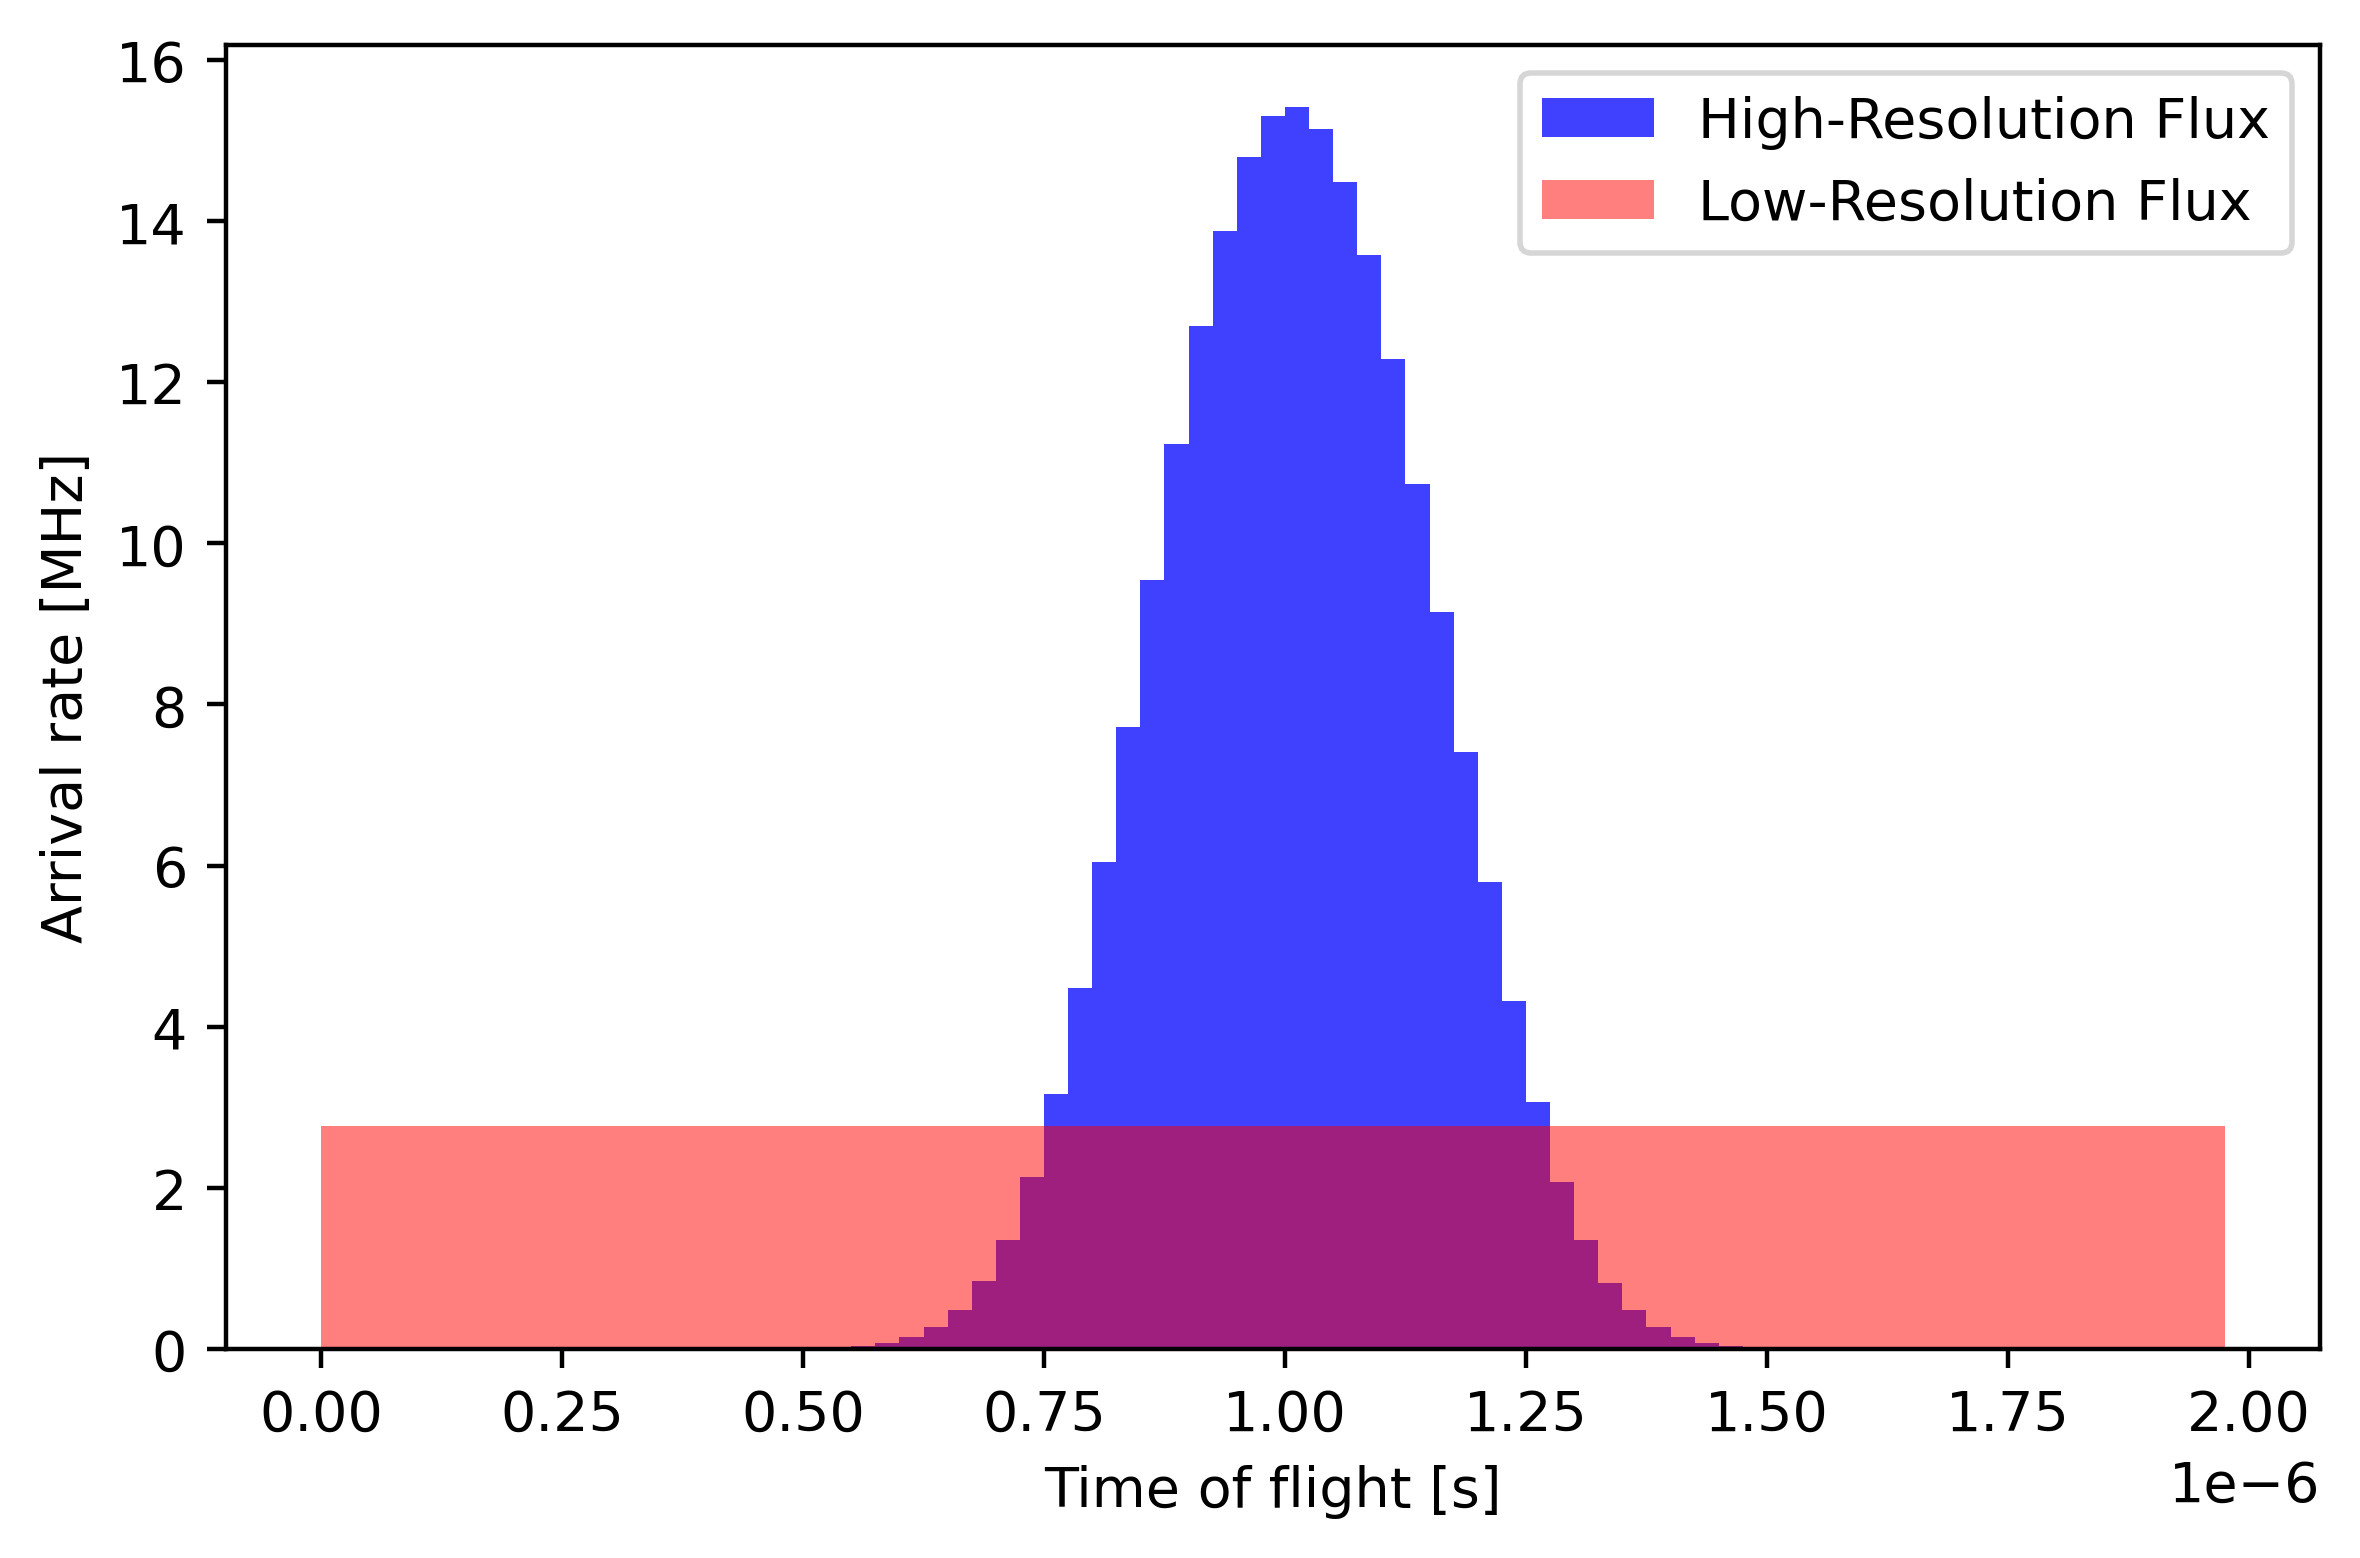

Histogram plot time elapsed: 0.994 sec


In [11]:
fname = r'\sim_amp2.5E+07_nshot1.0E+06_pwidth_1.2E+02.nc'
ds = xr.open_dataset(save_dir + subdir + fname)

start = time.time()

cnts = ds.time_tag
dt = dt_sim
flight_time = cnts * dt  # [s]
# Exclude specified t.o.f. bins
flight_time = flight_time[np.where((flight_time >= window_bnd[0]) & (flight_time < window_bnd[1]))]
n_shots = len(ds.sync_index)

ds.close()

bin_array = set_binwidth(t_sim_min, t_sim_max, dt)
n, bins = np.histogram(flight_time, bins=bin_array)
binwidth = np.diff(bins)[0]
N = n / binwidth / n_shots

# Now average the detections
n_tot = np.sum(n)
binwidth_tot = t_sim_max - t_sim_min  # [s]
rho_avg_det = n_tot / binwidth_tot / n_shots  # [Hz]

# Plot
fig = plt.figure(dpi=400)
ax1 = fig.add_subplot(111)
center = 0.5 * (bins[:-1]+bins[1:])
ax1.bar(center, N/1e6, align='center', width=binwidth, color='b', alpha=0.75, label='High-Resolution Flux')
ax1.bar((t_sim_max-t_sim_min-dt_sim)/2, rho_avg_det/1e6, width=t_sim_max-t_sim_min-dt_sim, align='center', color='red', alpha=0.5, label='Low-Resolution Flux')
ax1.set_xlabel('Time of flight [s]')
ax1.set_ylabel('Arrival rate [MHz]')
plt.legend()
plt.tight_layout()
plt.show()
print('Histogram plot time elapsed: {:.3} sec'.format(time.time() - start))

# Graveyard

# Compare Average Values

If $\rho(t)$ is gaussian, then the average value over a single bin is 
$$\bar{\rho}(t)=\frac{1}{T}\int_{0}^{T}\rho(t')dt'=\frac{1}{T}\int_{0}^{T}\left(A\exp(-\frac{(t'-\mu)^2}{2\sigma^2})+b\right)dt'$$
$$\bar{\rho}(t)=\frac{1}{T}\sqrt{\frac{\pi}{2}}A\sigma\left[erf\left(\frac{T-\mu}{\sqrt{2}\sigma}\right)-erf\left(-\frac{\mu}{\sqrt{2}\sigma}\right)\right]+b$$


In [265]:
# Analytic average of true function
erf = scipy.special.erf

T = t_sim_max - t_sim_min
A = amplitude  # [Hz]
sigma = laser_pulse_width  # [s]
mu = target_time  # [s]
b = background  # [Hz]

rho_avg_true = 1/T*np.sqrt(np.pi/2)*A*sigma*(erf((T-mu)/np.sqrt(2)/sigma)+b*T-erf(-mu/np.sqrt(2)/sigma))  # [Hz]
rho_avg_true = rho_avg_true[0]

# Now average the detections
n_tot = np.sum(n)
binwidth_tot = t_sim_max - t_sim_min  # [s]

rho_avg_det = n_tot / binwidth_tot / n_shots  # [Hz]

# Apply Muller correction
rho_avg_Muller = rho_avg_det / (1 - tD*rho_avg_det)
print('True avg flux: {:.2f} Hz'.format(rho_avg_true))
print('Detected avg flux: {:.2f} Hz'.format(rho_avg_det))
print('Muller corrected flux: {:.2f} Hz'.format(rho_avg_Muller))

True avg flux: 213909.23 Hz
Detected avg flux: 210408.50 Hz
Muller corrected flux: 211521.15 Hz
